# Point in Polygon Tests

# Setup

In [1]:
import numpy as np
import json
from pprint import pprint
from memory_profiler import profile

In [3]:
from astropy.io import fits
data = fits.open('../../PHAT_BEAST/b22_stats_toothpick_v1.1.fits', memmap=True)[1]

In [4]:
from numba import jit

In [294]:
vertices = [(42.08966338773695, 11.63993711820775),
 (42.16591939189332, 11.791014549991507),
 (42.172697703373885, 11.792076979097095),
 (42.15775460760991, 11.86325972917151),
 (42.10768753417391, 11.954628632252101)]

In [5]:
vertices = [(42.098136277087654, 11.957815919568866),
 (42.09613359415022, 11.967377781519161),
 (42.08534991679477, 11.969290140940114),
 (42.085658021862066, 11.862197300065922),
 (42.08673638959761, 11.833511714215039),
 (42.08750665226586, 11.818637706736803),
 (42.09536333148197, 11.737893094712094),
 (42.100909222693346, 11.713457225283562),
 (42.10614700883742, 11.695395930488562),
 (42.105992956303766, 11.693271072277387),
 (42.10768753417391, 11.677334635693562),
 (42.112463162717034, 11.644399333420326),
 (42.114157740587174, 11.63993711820775),
 (42.119087421663956, 11.641212046103561),
 (42.12263062993789, 11.644399333420326),
 (42.12478736540898, 11.64758662073709),
 (42.12524952300992, 11.650773908053855),
 (42.124633312875325, 11.645461762525914),
 (42.12694410088007, 11.649711478948268),
 (42.13664941049996, 11.655023624476208),
 (42.140192618773895, 11.663523057320914),
 (42.141579091576745, 11.742142811134446),
 (42.1405007238412, 11.793139408202684),
 (42.1395764086393, 11.799513982836213),
 (42.1398845137066, 11.835636572426214),
 (42.13834398837011, 11.912131468028571),
 (42.13834398837011, 11.910006609817394),
 (42.13572509529807, 11.923818188190042),
 (42.12771436354831, 11.94931648672416),
 (42.12802246861561, 11.950378915829749)]

In [6]:
points = np.vstack([data.data['DEC'], data.data['RA']])

In [7]:
points.T

array([[42.16295068, 11.94153659],
       [42.1134434 , 11.68024732],
       [42.11515299, 11.88223938],
       ...,
       [42.15991029, 11.69838903],
       [42.15988112, 11.69978689],
       [42.16066163, 11.69991191]])

In [280]:
vertices = np.array([[42.09, 11.94], [42.09, 11.90], [42.11, 11.90], [42.11, 11,95]])

In [12]:
vertices = np.array(vertices)

In [8]:
from matplotlib import pylab as plt

In [9]:
from matplotlib import patches

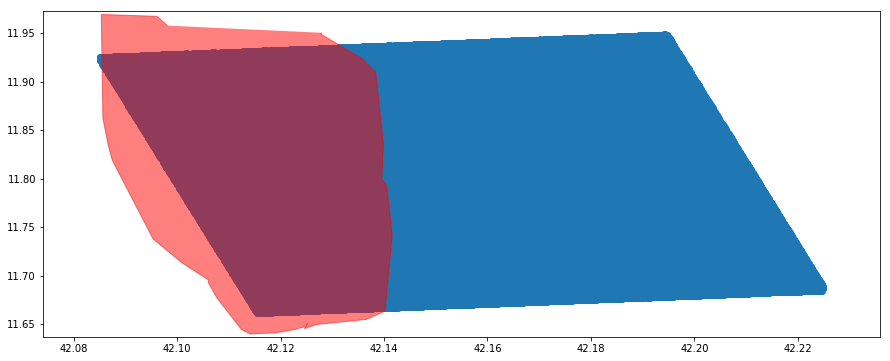

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
ax.scatter(data.data['DEC'], data.data['RA'])
ax.add_patch(patches.Polygon(np.array(vertices), closed=False, fill=True, color='r', alpha=0.5))

In [11]:
def plot(flagged):
    fig, ax = plt.subplots(1,1, figsize=(15,6))
    ax.scatter(data.data['DEC'], data.data['RA'])
    ax.add_patch(patches.Polygon(vertices, closed=False, fill=True, color='r', alpha=0.2))
    ax.scatter(data.data['DEC'][flagged], data.data['RA'][flagged], color='k')

## Other stuff

In [33]:
shapely_points = np.apply_along_axis(Point, 1, points.T)

In [21]:
def clip(subjectPolygon, clipPolygon):
   def inside(p):
      return(cp2[0]-cp1[0])*(p[1]-cp1[1]) > (cp2[1]-cp1[1])*(p[0]-cp1[0])
 
   def computeIntersection():
      dc = [ cp1[0] - cp2[0], cp1[1] - cp2[1] ]
      dp = [ s[0] - e[0], s[1] - e[1] ]
      n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
      n2 = s[0] * e[1] - s[1] * e[0] 
      n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
      return [(n1*dp[0] - n2*dc[0]) * n3, (n1*dp[1] - n2*dc[1]) * n3]
 
   outputList = subjectPolygon
   cp1 = clipPolygon[-1]
 
   for clipVertex in clipPolygon:
      cp2 = clipVertex
      inputList = outputList
      outputList = []
      s = inputList[-1]
 
      for subjectVertex in inputList:
         e = subjectVertex
         if inside(e):
            if not inside(s):
               outputList.append(computeIntersection())
            outputList.append(e)
         elif inside(s):
            outputList.append(computeIntersection())
         s = e
      cp1 = cp2
   return(outputList)
 

## GEOS via Shapely (21.8s)

In [671]:
# Option 1:  Shapely
# https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html
#import shapely.speedups
#shapely.speedups.enable()
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
polygon = Polygon(vertices)

In [672]:
shapely_points = [Point(points[:,i]) for i in range(points.shape[1])]

In [676]:
@jit(parallel=True)
def to_points(points):
    shapely_points = np.empty(points.shape[0], dtype=Point)
    for i in range(points.shape[0]):
        shapely_points[i] = Point(points[i])
    return shapely_points
_ = to_points(points.T)

In [677]:
shapely_points = to_points(points.T)

In [678]:
flags = [polygon.contains(pt) for pt in shapely_points]

In [679]:
@jit(parallel=True)
def to_flags(points):
    flags = np.zeros(points.shape[0], dtype=np.bool_)
    for i in range(points.shape[0]):
        flags[i] = polygon.contains(points[i])
    return flags
_ = to_flags(shapely_points)

In [680]:
flags = to_flags(shapely_points)

In [655]:
flags = to_flags(to_points(points.T))

In [685]:
%%timeit
polygon = Polygon(vertices)
shapely_points = to_points(points.T)
flags = to_flags(shapely_points)

21.8 s ± 1.34 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [684]:
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


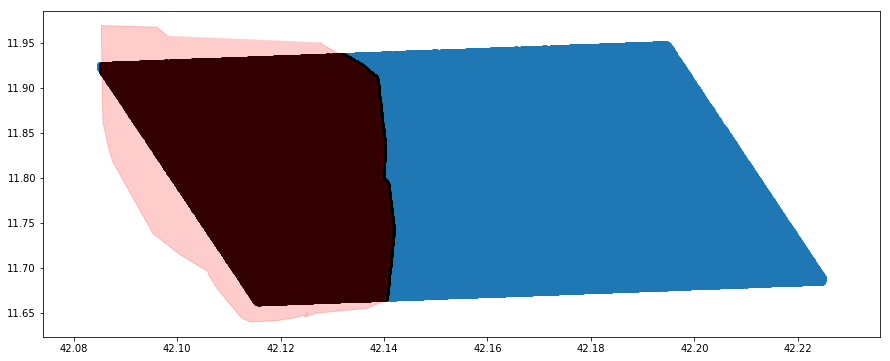

In [656]:
plot(flags)

### Performance

In [ ]:
%%timeit -o
polygon = Polygon(vertices)
shapely_points = to_points(points.T)
flags = to_flags(shapely_points)

In [ ]:
performances['Shapely (GEOS)'] = _

## Matplotlib Path (0.16s)

In [319]:
# Option 2:  Matplotlib
from matplotlib import path
import matplotlib.pyplot as plt
polygon = path.Path(vertices)

In [378]:
%%timeit
polygon = path.Path(vertices)
flags = polygon.contains_points(points.T)

164 ms ± 7.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [321]:
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0. 1. 1. ... 0. 0. 0.]
(633,866)  225,925.0


## Ray Tracing (best: 0.156s)

### Ray Tracing Python (60s)

In [686]:
# Option 3:  Ray Tracing
def ray_tracing(x, y, poly):
    n = len(poly)
    inside = False
    xints = 0.0
    p1x, p1y = poly[0]
    p2x, p2y = [0.0, 0.0]
    for i in range(n+1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

In [309]:
%%time
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = ray_tracing(*point, vertices)

Wall time: 41 s


In [687]:
%%timeit
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = ray_tracing(*point, vertices)

60 s ± 2.95 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba Accelerated (1.5s)

In [313]:
# Option 3:  Numba Ray Tracing
@jit(nopython=True, parallel=True)
def ray_tracing(x, y, poly):
    n = len(poly)
    inside = False
    xints = 0.0
    p1x, p1y = poly[0]
    p2x, p2y = [0.0, 0.0]
    for i in range(n+1):
        p2x, p2y = poly[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y-p1y)*(p2x-p1x)/(p2y-p1y)+p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

In [314]:
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = ray_tracing(*point, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0. 1. 1. ... 0. 0. 0.]
(633,866)  225,925.0


In [315]:
%%timeit 
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = ray_tracing(*point, vertices)

1.53 s ± 32.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba Envelope Accelerated (0.20s)

In [316]:
@jit(nopython=True, parallel=True)
def get_ray_flags(x, y, vertices):
    flags = np.zeros(len(x))
    for i in range(len(x)):
        flags[i] = ray_tracing(x[i], y[i], vertices)
    return flags
flags = get_ray_flags(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0. 1. 1. ... 0. 0. 0.]
(633,866)  225,925.0


In [318]:
%%timeit
flags = get_ray_flags(*points, vertices)

216 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba Envelope Accelerated with Empty Bool Array (0.172s)

In [322]:
@jit(nopython=True, parallel=True)
def get_ray_flags(x, y, vertices):
    flags = np.empty(len(x), dtype=np.bool_)
    for i in range(len(x)):
        flags[i] = ray_tracing(x[i], y[i], vertices)
    return flags

[False  True  True ... False False False]
(633,866)  225,925


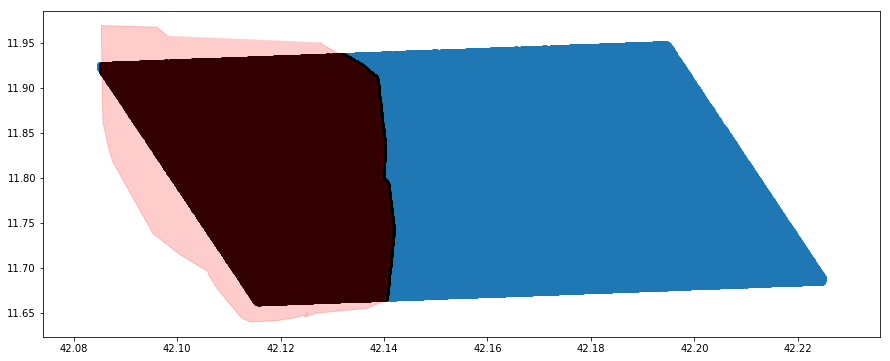

In [325]:
flags = get_ray_flags(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))
plot(flags)

In [326]:
%%timeit
flags = get_ray_flags(*points, vertices)

172 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Even-Odd Rule (Best: 0.038s)

"The Method

I run a semi-infinite ray horizontally (increasing x, fixed y) out from the test point, and count how many edges it crosses. At each crossing, the ray switches between inside and outside. This is called the **Jordan curve theorem**.

The case of the ray going through a vertex is handled correctly via a careful selection of inequalities. Don't mess with this code unless you're familiar with the idea of **Simulation of Simplicity**. This pretends to shift the ray infinitesimally down so that it either clearly intersects, or clearly doesn't touch. Since this is merely a conceptual, infinitesimal, shift, it never creates an intersection that didn't exist before, and never destroys an intersection that clearly existed before.

The ray is tested against each edge thus:

    Is the point in the half-plane to the left of the extended edge? and
    Is the point's Y coordinate within the edge's Y-range? 

Handling endpoints here is tricky."

### Python Function (52s)

In [692]:
# Option 4:  Even-odd Rule
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)
    i = 0
    j = num - 1
    c = False
    for i in range(num):
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c

In [693]:
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = isPointInPath(*point, vertices)

In [694]:
%%timeit
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = isPointInPath(*point, vertices)

1min 15s ± 5.89 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Numba Accelerated (1.4s)

In [327]:
@jit(nopython=True, parallel=True)
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = False
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c
flags = isPointInPath(*point, vertices)

In [278]:
%%timeit
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = isPointInPath(*point, vertices)

1.4 s ± 31.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [328]:
flags = np.zeros(len(points.T))
for i, point in enumerate(points.T):
    flags[i] = isPointInPath(*point, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0. 1. 1. ... 0. 0. 0.]
(633,866)  225,925.0


### Numba Envelope Accelerated (0.100s)

In [300]:
@jit(nopython=True, parallel=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.zeros(len(x))
    for i in range(len(x)):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags
flags = get_even_odd_flags(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0. 1. 1. ... 0. 0. 0.]
(633,866)  225,925.0


In [302]:
%%timeit -n20 -r20
flags = get_even_odd_flags(*points, vertices)

99.9 ms ± 483 µs per loop (mean ± std. dev. of 20 runs, 20 loops each)


### Numba Envelope Accelerated with Empty Bool Array (0.062s)

In [293]:
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = False
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c = not c
        j = i
    return c
flags = isPointInPath(*point, vertices)

In [294]:
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.empty(len(x), dtype=np.bool_)
    for i in range(len(x)):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags
flags = get_even_odd_flags(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [298]:
%%timeit -n20 -r20
flags = get_even_odd_flags(*points, vertices)

61.6 ms ± 954 µs per loop (mean ± std. dev. of 20 runs, 20 loops each)


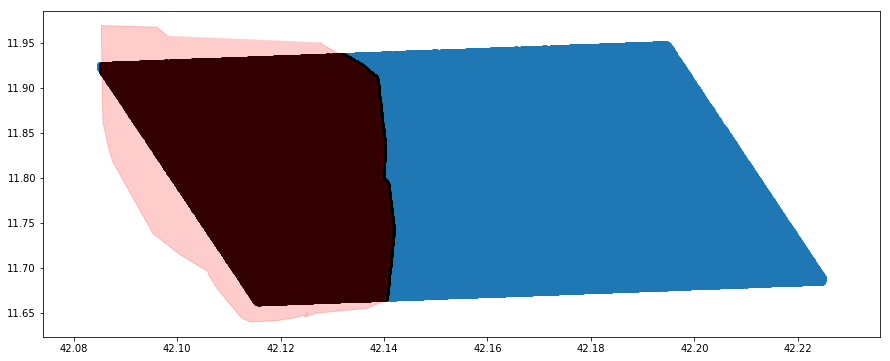

In [314]:
flags = get_even_odd_flags(*points, vertices)
plot(flags)

### Explicit first Loop integer (0.051s)

In [333]:
@jit(nopython=True, parallel=True)
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = poly.shape[0]  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    # Explicit first lop
    c = ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1]))
    # Loop over vertices
    for i in range(1, num):
        j = i-1
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c += 1
    return c%2
flags = isPointInPath(*point, vertices)

In [334]:
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.empty(x.shape[0], dtype=np.bool_)
    for i in range(x.shape[0]):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags
flags = get_even_odd_flags(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [335]:
%%timeit -n20 -r20
flags = get_even_odd_flags(*points, vertices)

51.3 ms ± 705 µs per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [336]:
%%timeit -n40 -r40
flags = get_even_odd_flags(*points, vertices)

51.8 ms ± 1.43 ms per loop (mean ± std. dev. of 40 runs, 40 loops each)


### Explicit first Loop bool (0.047s)

In [289]:
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)
def isPointInPath(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = poly.shape[0]  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    # Explicit first lop
    c = ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1]))
    # Loop over vertices
    for i in range(1, num):
        j = i-1
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c = not c
    return c
flags = isPointInPath(*point, vertices)

In [290]:
@jit(nopython=True, parallel=True, nogil=True, fastmath=True)
def get_even_odd_flags(x, y, vertices):
    flags = np.empty(x.shape[0], dtype=np.bool_)
    for i in range(x.shape[0]):
        flags[i] = isPointInPath(x[i], y[i], vertices)
    return flags
flags = get_even_odd_flags(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [291]:
%%timeit -n20 -r20
flags = get_even_odd_flags(*points, vertices)

47 ms ± 1.28 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


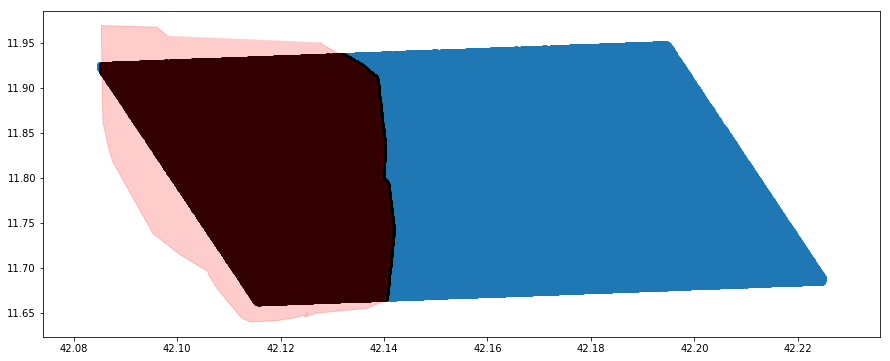

In [83]:
flags = get_even_odd_flags(*points, vertices)
plot(flags)

### Explicit First Loop Bool Vectorized (0.038s)

In [374]:
@jit(nopython=True, parallel=True)
def vec_point_in_polygon(x, y, poly):
    num = poly.shape[0]  # Number of vertices
    i = 0                # First Vertex
    j = num - 1          # Previous Vertex
    # Explicit first lop
    c = np.logical_and(
        np.logical_xor((poly[i][1] > y), (poly[j][1] > y)),
        (x < poly[i][0] + (poly[j][0]-poly[i][0]) * (y-poly[i][1]) / (poly[j][1]-poly[i][1]))
    )
    for i in range(1, num):
        j = i-1
        c = np.logical_xor(
            c,
            np.logical_and(
                np.logical_xor((poly[i][1] > y), (poly[j][1] > y)),
                (x < poly[i][0] + (poly[j][0]-poly[i][0]) * (y-poly[i][1]) / (poly[j][1]-poly[i][1]))
            )
        )
    return c
c = vec_point_in_polygon(*points, poly)
print(c)
print("({:,})  {:,}".format(c.shape[0], c.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [349]:
%%timeit -n20 -r20
flags = vec_point_in_polygon(*points, poly)

38.5 ms ± 1.27 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [350]:
%%timeit -n40 -r40
flags = vec_point_in_polygon(*points, poly)

38.3 ms ± 556 µs per loop (mean ± std. dev. of 40 runs, 40 loops each)


###  WRONG Explicit first Loop integer vectorized (0.046s)

In [352]:
@jit(nopython=True, parallel=True)
def vec_point_in_polygon(x, y, poly):
    num = poly.shape[0]  # Number of vertices
    i = 0                # First Vertex
    j = num - 1          # Previous Vertex
    # Explicit first lop
    c = np.logical_and(
        np.logical_xor((poly[i][1] > y), (poly[j][1] > y)),
        (x < poly[i][0] + (poly[j][0]-poly[i][0]) * (y-poly[i][1]) / (poly[j][1]-poly[i][1]))
    )
    for i in range(1, num):
        j = i-1
        c += np.logical_and(
                np.logical_xor((poly[i][1] > y), (poly[j][1] > y)),
                (x < poly[i][0] + (poly[j][0]-poly[i][0]) * (y-poly[i][1]) / (poly[j][1]-poly[i][1]))
            )
        
    return c%2
c = vec_point_in_polygon(*points, vertices)
print(c)
print("({:,})  {:,}".format(c.shape[0], c.sum()))

[0 1 1 ... 0 0 0]
(633,866)  225,960


In [344]:
%%timeit -n20 -r20
flags = vec_point_in_polygon(*points, poly)

48.1 ms ± 1.36 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [341]:
%%timeit -n20 -r20
flags = vec_point_in_polygon(x, y, poly)

47.2 ms ± 1.36 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [254]:
%%timeit -n20 -r20
flags = vec_point_in_polygon(x, y, poly)

46.6 ms ± 2.15 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


In [259]:
%%timeit -n30 -r30
flags = vec_point_in_polygon(x, y, poly)

46.3 ms ± 716 µs per loop (mean ± std. dev. of 30 runs, 30 loops each)


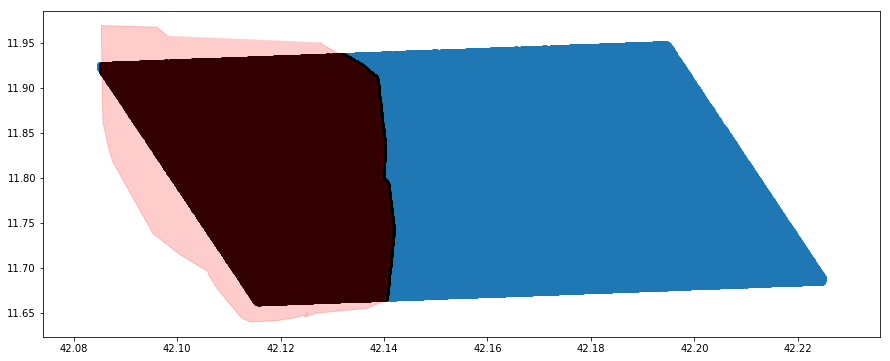

In [203]:
plot(flags)

### Theoretical Limitations

In [ ]:
if_operations_per_point = ((1)+1+(1))+1+(1+1+(1)+1+(1)+1+(1))

In [ ]:
    # Loop over vertices
    for i in range(1, num):
        j = i-1
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        if ((poly[i][1] > y) != (poly[j][1] > y)) and \
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1])):
            c += 1


## Even-Odd Rule for Arrays 

### Simple NumPy Array Computation (0.598s)

In [357]:
#@jit(nopython=True, parallel=True)
def is_point_in_path(n, x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = np.zeros(n, dtype=np.bool_)
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        mask = np.logical_and(
                np.not_equal(poly[i][1]>y, poly[j][1] > y),
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1]))
        )
        np.invert(c, out=c, where=mask)

        j = i
    return c
flags = is_point_in_path(len(points[0]), *points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


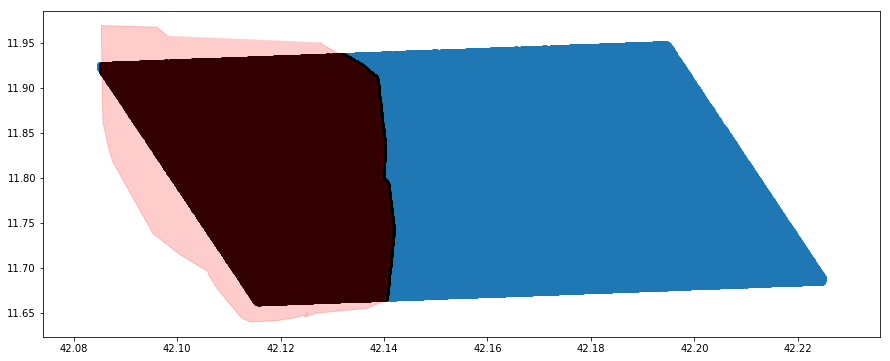

In [358]:
flags = is_point_in_path(len(points[0]), *points, vertices)
plot(flags)

In [333]:
%%timeit
flags = is_point_in_path(len(points[0]), *points, vertices)

640 ms ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [359]:
%%timeit -r20 -n20
flags = is_point_in_path(len(points[0]), *points, vertices)

598 ms ± 76.9 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


### Numba NumPy Array (0.082s)

In [361]:
@jit(nopython=True, parallel=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = np.zeros(len(x), dtype=np.bool_)
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        mask = np.logical_and(
                np.not_equal(poly[i][1]>y, poly[j][1] > y),
                (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) /
                                (poly[j][1] - poly[i][1]))
        )
        c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

        j = i
    return c
flags = is_point_in_path(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [362]:
%%timeit
flags = is_point_in_path(*points, vertices)

82.4 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


###  NumpyArray Numba (NoPython, Parallel, Fastmath: 0.077s)

In [363]:
@jit(nopython=True, parallel=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = 0            # First Vertex
    j = num - 1      # Previous Vertex
    c = np.zeros(len(x), dtype=np.bool_)
    # Loop over vertices
    for i in range(num):
        # if (a) and (b)
        # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
        # a) XOR(), false if either vertex is higher than point
        # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
        #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
        #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
        #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
        # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
        # b) 
        mask = np.logical_and(
            np.not_equal(
                poly[i][1]>y, 
                poly[j][1] > y
            ),
            (x < poly[i][0] + (poly[j][0] - poly[i][0]) * (y - poly[i][1]) / (poly[j][1] - poly[i][1]))
        )
        c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

        j = i
    return c
flags = is_point_in_path(*points, vertices)
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [364]:
%%timeit
flags = is_point_in_path(*points, vertices)

77.9 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [366]:
%%timeit -r20 -n20
flags = is_point_in_path(*points, vertices)

76.7 ms ± 1.02 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


### More Array Computation (0.656s)

#### WRONG Using expand_dims (0.67s)

In [367]:
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1)  # Previous Vertex
    i = np.expand_dims(np.transpose(i),2)
    j = np.expand_dims(np.transpose(j),2)
    c = np.zeros(len(x), dtype=np.bool_)
    # Loop over vertices
    # if (a) and (b)
    # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
    # a) XOR(), false if either vertex is higher than point
    # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
    #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
    #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
    #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
    # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
    # b) 
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[1], y), 
            np.greater(j[1], y)
        ),
        np.less(
            x, 
            i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
        )
    )
    c = np.sum(mask, axis=0) % 2
    #c = np.logical_xor.reduce(mask)
    #c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

    return c

flags = is_point_in_path(*points, np.array(vertices))
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0 1 0 ... 0 0 0]
(633,866)  62,810


In [368]:
%%timeit
flags = is_point_in_path(*points, np.array(vertices))

612 ms ± 8.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Using newaxis (0.656s)

In [369]:
#@jit(nopython=True, parallel=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1, 0)  # Previous Vertex
    c = np.zeros(len(x), dtype=np.bool_)
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[:,1,np.newaxis], y), 
            np.greater(j[:,1,np.newaxis], y)
        ),
        np.less(
            x, 
            i[:,0,np.newaxis] + (j[:,0,np.newaxis] - i[:,0,np.newaxis]) * (y - i[:,1,np.newaxis]) /
                            (j[:,1,np.newaxis] - i[:,1,np.newaxis]))
    )
    c = np.logical_xor.reduce(mask)
    #c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

    return c
flags = is_point_in_path(*points, np.array(vertices))
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True  True ... False False False]
(633,866)  225,925


In [371]:
%%timeit -r20 -n20
flags = is_point_in_path(*points, np.array(vertices))

656 ms ± 79.5 ms per loop (mean ± std. dev. of 20 runs, 20 loops each)


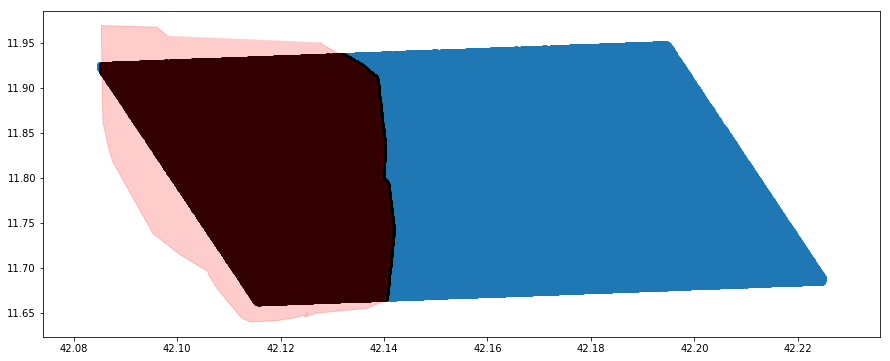

In [20]:
plot(flags)

#### WRONG Using Numba and Expand_dims (0.18s)

In [372]:
@jit(nopython=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1)  # Previous Vertex
    i = np.expand_dims(np.transpose(i),2)
    j = np.expand_dims(np.transpose(j),2)
    #c = np.zeros(len(x), dtype=np.bool_)
    #print(i.shape)
    #print(j.shape)
    #print(x.shape, y.shape)
    x = np.expand_dims(x,0)
    y = np.expand_dims(y,0)
    #print(x.shape, y.shape)
    
    #print(np.logical_and(
    #    np.not_equal(
    #        np.greater(i[1], y), 
    #        np.greater(j[1], y)
    #    ),
    #    np.less(
    #        x, 
    #        i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
    #    )
    #).shape)
    #print(np.not_equal(
    #        np.greater(i[1], y), 
    #        np.greater(j[1], y)
    #    ).shape)
    #print(np.less(
    #        x, 
    #        i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
    #    ).shape)
    #print(np.greater(i[1], y).shape)
    #print((i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])).shape)
    # Loop over vertices
    # if (a) and (b)
    # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
    # a) XOR(), false if either vertex is higher than point
    # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
    #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
    #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
    #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
    # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
    # b) 
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[1], y), 
            np.greater(j[1], y)
        ),
        np.less(
            x, 
            i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
        )
    )
    c = np.sum(mask, axis=0) % 2
    #c = np.logical_xor.reduce(mask)
    #c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)

    return c

flags = is_point_in_path(*points, np.array(vertices))
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[0 1 0 ... 0 0 0]
(633,866)  62,810


In [605]:
%%timeit
flags = is_point_in_path(*points, np.array(vertices))

175 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


NOTE: Parallel fails due to broadcasting problem

#### WRONG Explicit logical xor reduction (0.14ms)

In [373]:
@jit(nopython=True, fastmath=True)
def red(mask):
    """ 140ms """
    c = np.zeros(len(x), dtype=np.bool_)
    for idx in range(num):
        c = np.logical_xor(mask[idx], c)
    return c

#@jit(nopython=True, fastmath=True)
#def red(mask):
#    """ 200ms """
#    return np.sum(mask, axis=0) % 2


@jit(nopython=True, fastmath=True)
def is_point_in_path(x, y, poly):
    """
    x, y -- x and y coordinates of point
    poly -- a list of tuples [(x, y), (x, y), ...]
    -------------------------------------------------
    PNPOLY - Point Inclusion in Polygon Test
    W. Randolph Franklin (WRF) 
    source:  https://wrf.ecse.rpi.edu/Research/Short_Notes/pnpoly.html
    """
    num = len(poly)  # Number of vertices
    i = poly            # First Vertex
    j = np.roll(poly, 1)  # Previous Vertex
    i = np.expand_dims(np.transpose(i),2)
    j = np.expand_dims(np.transpose(j),2)
    # Loop over vertices
    # if (a) and (b)
    # a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
    # a) XOR(), false if either vertex is higher than point
    # b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
    #                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
    #                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
    #                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
    # b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
    # b) 
    mask = np.logical_and(
        np.not_equal(
            np.greater(i[1], y), 
            np.greater(j[1], y)
        ),
        np.less(
            x, 
            i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
        )
    )

    return red(mask)

flags = is_point_in_path(*points, np.array(vertices))
print(flags)
print("({:,})  {:,}".format(flags.shape[0], flags.sum()))

[False  True False ... False False False]
(633,866)  62,810


In [640]:
%%timeit
is_point_in_path(*points, np.array(vertices))

141 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Logical Reduce Operations WIP

In [669]:
poly = vertices
x, y = points

num = len(poly)  # Number of vertices
i = poly            # First Vertex
j = np.roll(poly, 1)  # Previous Vertex
i = np.expand_dims(np.transpose(i),2)
j = np.expand_dims(np.transpose(j),2)
c = np.zeros(len(x), dtype=np.bool_)
# Loop over vertices
# if (a) and (b)
# a) ((vertex[1][y] > pt[y]) != (vertex[0][y] > pt[y]))
# a) XOR(), false if either vertex is higher than point
# b) x < (vertex[1][x] + (y - vertex[1][y])*(vertex[0][x]-vertex[1][x])/(vertex[0][y]-vertex[1][y]))
#                                   slope = (vertex[1][y]-vertex[0][y])/ (vertex[1][x]-vertex[0][x])
#                                         =-(vertex[0][y]-vertex[1][y])/-(vertex[0][x]-vertex[1][x])
#                                         = (vertex[0][y]-vertex[1][y])/ (vertex[0][x]-vertex[1][x])
# b) x < (vertex[1][x] + (y - vertex[1][y])/slope)
# b) 
mask = np.logical_and(
    np.not_equal(
        np.greater(i[1], y), 
        np.greater(j[1], y)
    ),
    np.less(
        x, 
        i[0] + (j[0] - i[0]) * (y - i[1]) / (j[1] - i[1])
    )
)
c = np.sum(mask, axis=0) % 2
#c = np.logical_xor.reduce(mask)
#c[mask] = ~c[mask] #np.invert(c, out=c, where=mask)


In [556]:
%%timeit
np.logical_xor.reduce(mask)

23.5 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [555]:
%%timeit
np.sum(mask, axis=0) % 2

41 ms ± 3.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [544]:
 np.greater(np.expand_dims(np.array(vertices).T[1], 1), points[1])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

# Overview

## Time Comparison

In [382]:
time_comparison = {
    'Shapely (GEOS)': 23,
    'Matplotlib Path': 0.16,
    'Ray Tracing': 0.172,
    'SoS Ray Tracing Iterated': 0.062,
    'SoS Ray Tracing Vectorized': 0.038
}

Text(0, 0.5, 'Compute Time (seconds)')

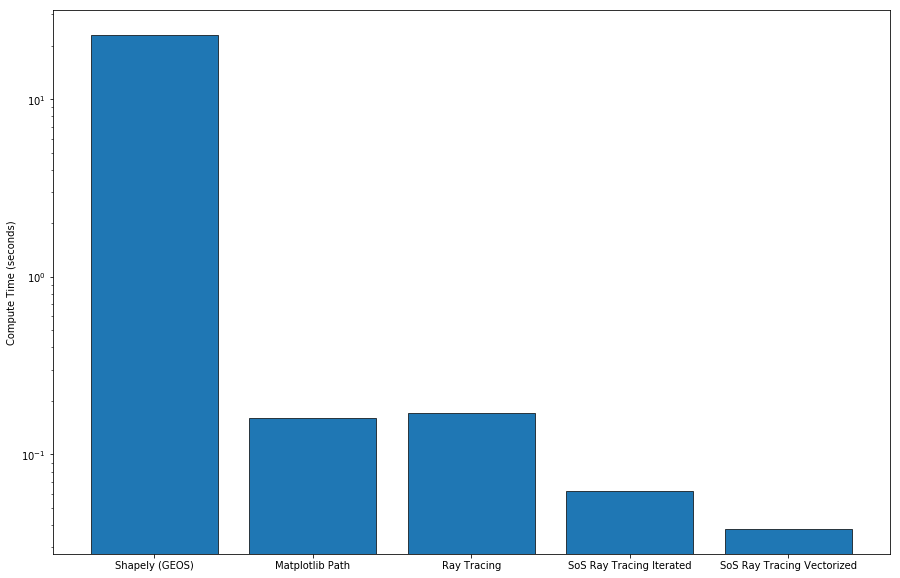

In [393]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
ax.bar(time_comparison.keys(), time_comparison.values(), edgecolor='black', linewidth=0.7)
ax.set_yscale('log')
ax.set_ylabel('Compute Time (seconds)')

In [394]:
time_comparison = {
    'Shapely (GEOS)': 23,
    'Matplotlib Path': 0.16,
    'Ray Tracing': {
        'Pure Python': 60,
        'Numba Looped': 1.5,
        'Numba Envelope': 0.2,
        'Numba Envelope w/ memory pre-allocation': 0.172
    },
    'SoS Ray Tracing': {
        'Pure Python': 52,
        'Numba Looped': 1.4,
        'Numba Envelope': 0.1,
        'Numba Envelope w/ memory pre-allocation': 0.062,
        '+ Explicit first loop in bool': 0.047,
        '+ Explicit first loop in bool vectorized': 0.038
    }
}

In [698]:
ray_tracing = {
    'RT: Pure Python': 60,
    'RT: Numba Looped': 1.5,
    'RT: Numba Envelope': 0.216,
    '+ memory pre-alloc.': 0.172
}
sos = {
    'SoS RT: Pure Python': 52,
    'SoS RT: Numba Looped': 1.4,
    'SoS RT: Numba Envelope': 0.0999,
    '+ mem. pre-alloc.': 0.0616,
    '+ Explicit 1st loop (bool)': 0.047, 
    '+ Explicit 1st loop (bool) vectorized': 0.038,
}
time_comparison = {
    'Shapely (GEOS)': 21.8,
    'Matplotlib Path': 0.16,
    **ray_tracing,
    **sos
}
colors = [
    # Orange, Purple 
    [0.90,0.40,0.00,0.75], [0.50,0.00,0.40,1.00],
    # Greens
    [0.00,0.25,0.00,1.00], [0.00,0.25,0.00,0.80], [0.00,0.25,0.00,0.60], [0.00,0.25,0.00,0.40],
    # Blues
    [0.00,0.00,0.30,0.90], [0.00,0.00,0.30,0.78], [0.00,0.00,0.30,0.66], [0.00,0.00,0.30,0.54], 
    [0.00,0.00,0.30,0.42], [0.00,0.00,0.30,0.30]
]

In [700]:
stds = {
    'Shapely (GEOS)': 1.34,
    'Matplotlib Path': 0.00732,
    'RT: Pure Python': 2.95,
    'RT: Numba Looped': 0.0324,
    'RT: Numba Envelope': 0.0047,
    '+ memory pre-alloc.': 0.0026,
    'SoS RT: Pure Python': 0,
    'SoS RT: Numba Looped': 0.0311,
    'SoS RT: Numba Envelope': 0.000483,
    '+ mem. pre-alloc.': 0.000954,
    '+ Explicit 1st loop (bool)': 0.00128,
    '+ Explicit 1st loop (bool) vectorized': 0.000556
}

In [ ]:
time_comparison_values = np.array(time_comparison.values())[1,:]
print(time_comparison_values.shape)
time_comparison_std = np.array(time_comparison.values())[2,:]
time_comparison_keys = list(time_comparison.keys())


Text(0.5, 1.0, 'Point-in-Polygon selection performance comparison')

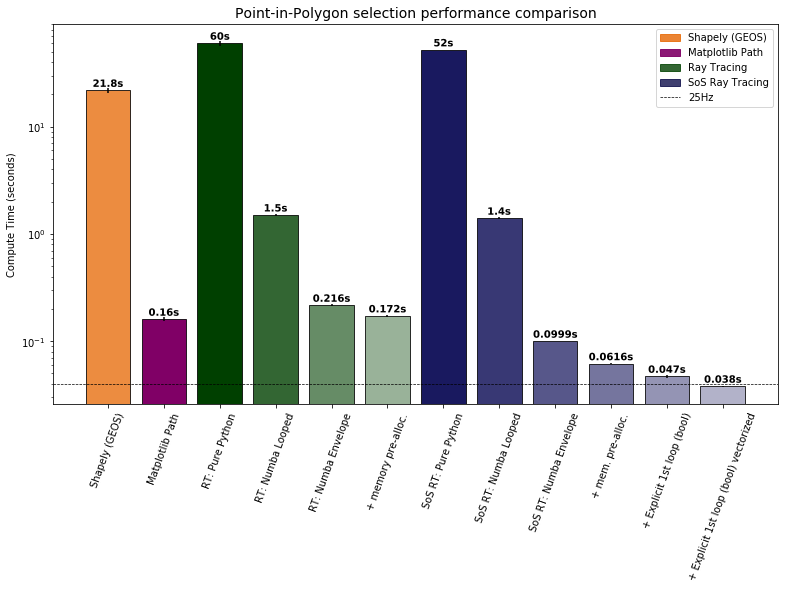

In [717]:
fig, ax = plt.subplots(1,1,figsize=(13,7))
ax.bar(time_comparison.keys(), time_comparison.values(), yerr=stds.values(),
       edgecolor='black', linewidth=0.8, color=colors)
ax.set_yscale('log')
ax.set_ylabel('Compute Time (seconds)')
ax.xaxis.set_tick_params(rotation=70)

# Reference of refresh rate
ref = ax.axhline(1/25, label='25Hz', color='k', linestyle="--", linewidth=0.7)

# Legend
import matplotlib.patches as mpatches
orange_patch = mpatches.Patch(color=[0.90,0.40,0.00,0.80], label='Shapely (GEOS)')
purple_patch = mpatches.Patch(color=[0.50,0.00,0.40,0.90], label='Matplotlib Path')
green_patch  = mpatches.Patch(color=[0.00,0.25,0.00,0.80], label='Ray Tracing')
blue_patch   = mpatches.Patch(color=[0.00,0.00,0.25,0.75], label='SoS Ray Tracing')
ax.legend(handles=[orange_patch, purple_patch, green_patch, blue_patch, ref])

# Value
import matplotlib.patheffects as path_effects
y = list(time_comparison.values())
for i, v in enumerate(y):
    label_text = ax.text(i, v*1.08, str(v)+"s", horizontalalignment='center', fontweight='demi')#, fontweight='bold', color=colors[i])
    # Ensure readability with large errorbars
    label_text.set_path_effects([
        path_effects.Stroke(linewidth=1, foreground='white'),
        path_effects.Normal()
    ])

# Title
ax.set_title('Point-in-Polygon selection performance comparison', fontsize=14)
#fig.tight_layout()

In [708]:
0.16/0.038

4.2105263157894735

## Throughput

In [721]:
reference_rate = 30
reference_time = 1/reference_rate
data_length = points.shape[1]

In [728]:
throughput = {
    key: (data_length*reference_time)/time_comparison[key]
    for key in time_comparison.keys()
}

Text(0.5, 1.0, 'Point-in-Polygon selection throughput\n(computed points within 30Hz)')

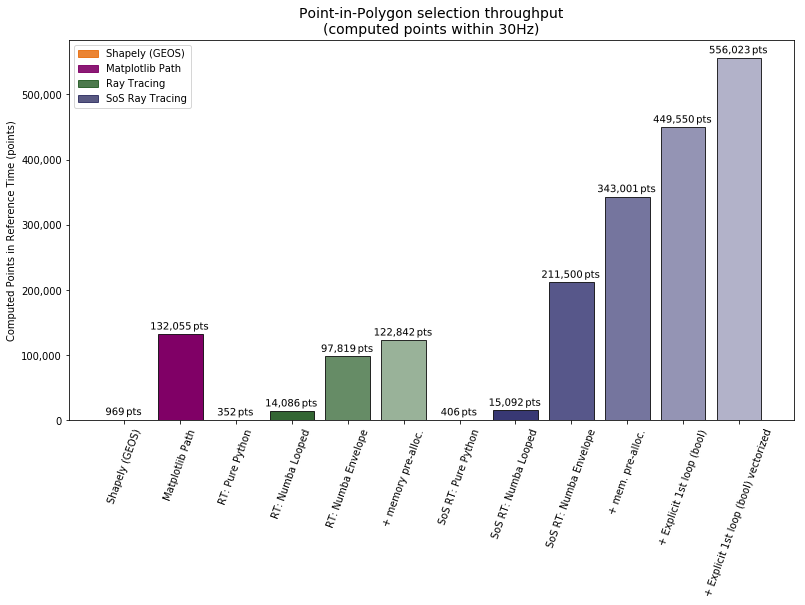

In [755]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(1,1,figsize=(13,7))
ax.bar(throughput.keys(), throughput.values(), #yerr=stds.values(),
       edgecolor='black', linewidth=0.8, color=colors)
#ax.set_yscale('log')
ax.set_ylabel('Computed Points in Reference Time (points)')
ax.xaxis.set_tick_params(rotation=70)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))


# Legend
import matplotlib.patches as mpatches
orange_patch = mpatches.Patch(color=[0.90,0.40,0.00,0.80], label='Shapely (GEOS)')
purple_patch = mpatches.Patch(color=[0.50,0.00,0.40,0.90], label='Matplotlib Path')
green_patch  = mpatches.Patch(color=[0.00,0.25,0.00,0.70], label='Ray Tracing')
blue_patch   = mpatches.Patch(color=[0.00,0.00,0.25,0.65], label='SoS Ray Tracing')
ax.legend(handles=[orange_patch, purple_patch, green_patch, blue_patch])

# Value
import matplotlib.patheffects as path_effects
y = list(throughput.values())
for i, v in enumerate(y):
    label_text = ax.text(i, v+7000, "{:,.0f}".format(v)+"$\,$pts", horizontalalignment='center')#, fontweight='demi')#, fontweight='bold', color=colors[i])
    # Ensure readability with large errorbars
    label_text.set_path_effects([
        path_effects.Stroke(linewidth=1, foreground='white'),
        path_effects.Normal()
    ])

# Title
ax.set_title('Point-in-Polygon selection throughput\n(computed points within {}Hz)'.format(reference_rate), fontsize=14)
#fig.tight_layout()

In [756]:
vertices.min(0)

array([42.08534992, 11.63993712])

In [758]:
"a" + "b"

'ab'

In [767]:
import ast
ast.literal_eval("[[42.13236576 11.90331655]\n [42.11873477 11.85733264]\n [42.13716759 11.77498936]\n [42.15838856 11.72045031]]".replace(" ", ","))

[[42.13236576, 11.90331655],
 [42.11873477, 11.85733264],
 [42.13716759, 11.77498936],
 [42.15838856, 11.72045031]]

In [774]:
np.ones((1, 1024), dtype=np.double).nbytes/1024

8.0

In [785]:
import tempfile

In [916]:
tf = tempfile.TemporaryFile(mode='w+t', encoding='utf-8')
pd.DataFrame(points.T).to_csv(tf, encoding='utf-8', index=False)
print(tf.read(10))

In [917]:
tf.seek(0)

0

In [990]:
getsizeof(tf.read(100000000))

9534173

In [996]:
pd.DataFrame(points.T)[:10]

,0,1
0,42.162951,11.941537
1,42.113443,11.680247
2,42.115153,11.882239
3,42.180174,11.675622
4,42.183232,11.889462
5,42.113141,11.913323
6,42.180077,11.902654
7,42.174189,11.913566
8,42.109306,11.912748
9,42.129936,11.877962


In [998]:
tf.read(1)

ValueError: I/O operation on closed file.

In [930]:
tf.location

AttributeError: '_io.TextIOWrapper' object has no attribute 'location'

In [915]:
pd.DataFrame(points.T).head()

,0,1
0,42.162951,11.941537
1,42.113443,11.680247
2,42.115153,11.882239
3,42.180174,11.675622
4,42.183232,11.889462


In [1000]:
data.data['name'].dtype

dtype('<U100')

In [1012]:
data.data['inside_chipgap'].dtype

dtype('bool')

In [1013]:
data.data['field'].dtype

dtype('>i8')

In [1016]:
data.data['Pmax'].dtype

dtype('>f8')

In [1005]:
pprint(dict(data.columns.dtype.descr))

{'Av_Best': '<f8',
 'Av_Exp': '<f8',
 'Av_p16': '<f8',
 'Av_p50': '<f8',
 'Av_p84': '<f8',
 'DEC': '<f8',
 'HST_ACS_WFC_F475W': '<f8',
 'HST_ACS_WFC_F814W': '<f8',
 'HST_WFC3_F110W': '<f8',
 'HST_WFC3_F160W': '<f8',
 'HST_WFC3_F275W': '<f8',
 'HST_WFC3_F336W': '<f8',
 'M_act_Best': '<f8',
 'M_act_Exp': '<f8',
 'M_act_p16': '<f8',
 'M_act_p50': '<f8',
 'M_act_p84': '<f8',
 'M_ini_Best': '<f8',
 'M_ini_Exp': '<f8',
 'M_ini_p16': '<f8',
 'M_ini_p50': '<f8',
 'M_ini_p84': '<f8',
 'Name': '|S100',
 'Pmax': '<f8',
 'Pmax_indx': '<i8',
 'RA': '<f8',
 'Rv_A_Best': '<f8',
 'Rv_A_Exp': '<f8',
 'Rv_A_p16': '<f8',
 'Rv_A_p50': '<f8',
 'Rv_A_p84': '<f8',
 'Rv_Best': '<f8',
 'Rv_Exp': '<f8',
 'Rv_p16': '<f8',
 'Rv_p50': '<f8',
 'Rv_p84': '<f8',
 'Z_Best': '<f8',
 'Z_Exp': '<f8',
 'Z_p16': '<f8',
 'Z_p50': '<f8',
 'Z_p84': '<f8',
 'chi2min': '<f8',
 'chi2min_indx': '<i8',
 'f_A_Best': '<f8',
 'f_A_Exp': '<f8',
 'f_A_p16': '<f8',
 'f_A_p50': '<f8',
 'f_A_p84': '<f8',
 'field': '<i8',
 'inside_brick': 

In [1007]:
data.data.columns.dtype.fields

mappingproxy({'M_act_Exp': (dtype('float64'), 0),
              'Pmax': (dtype('float64'), 8),
              'logHST_WFC3_F160W_nd_p50': (dtype('float64'), 16),
              'mbol_Best': (dtype('float64'), 24),
              'logHST_WFC3_F160W_nd_p16': (dtype('float64'), 32),
              'Rv_p84': (dtype('float64'), 40),
              'logF_QION_wd_p84': (dtype('float64'), 48),
              'logGALEX_NUV_wd_p50': (dtype('float64'), 56),
              'logL_p84': (dtype('float64'), 64),
              'logHST_WFC3_F110W_wd_p84': (dtype('float64'), 72),
              'logHST_WFC3_F110W_nd_Best': (dtype('float64'), 80),
              'logF_UV_6_13e_wd_p50': (dtype('float64'), 88),
              'logGALEX_FUV_nd_p50': (dtype('float64'), 96),
              'M_ini_Best': (dtype('float64'), 104),
              'logF_QION_wd_p16': (dtype('float64'), 112),
              'logF_UV_6_13e_nd_p50': (dtype('float64'), 120),
              'RA': (dtype('float64'), 128),
              'M_act_p16': (d

In [1009]:
pprint(dict(data.data.dtype.descr))

{'Av_Best': '>f8',
 'Av_Exp': '>f8',
 'Av_p16': '>f8',
 'Av_p50': '>f8',
 'Av_p84': '>f8',
 'DEC': '>f8',
 'HST_ACS_WFC_F475W': '>f8',
 'HST_ACS_WFC_F814W': '>f8',
 'HST_WFC3_F110W': '>f8',
 'HST_WFC3_F160W': '>f8',
 'HST_WFC3_F275W': '>f8',
 'HST_WFC3_F336W': '>f8',
 'M_act_Best': '>f8',
 'M_act_Exp': '>f8',
 'M_act_p16': '>f8',
 'M_act_p50': '>f8',
 'M_act_p84': '>f8',
 'M_ini_Best': '>f8',
 'M_ini_Exp': '>f8',
 'M_ini_p16': '>f8',
 'M_ini_p50': '>f8',
 'M_ini_p84': '>f8',
 'Name': '|S100',
 'Pmax': '>f8',
 'Pmax_indx': '>i8',
 'RA': '>f8',
 'Rv_A_Best': '>f8',
 'Rv_A_Exp': '>f8',
 'Rv_A_p16': '>f8',
 'Rv_A_p50': '>f8',
 'Rv_A_p84': '>f8',
 'Rv_Best': '>f8',
 'Rv_Exp': '>f8',
 'Rv_p16': '>f8',
 'Rv_p50': '>f8',
 'Rv_p84': '>f8',
 'Z_Best': '>f8',
 'Z_Exp': '>f8',
 'Z_p16': '>f8',
 'Z_p50': '>f8',
 'Z_p84': '>f8',
 'chi2min': '>f8',
 'chi2min_indx': '>i8',
 'f_A_Best': '>f8',
 'f_A_Exp': '>f8',
 'f_A_p16': '>f8',
 'f_A_p50': '>f8',
 'f_A_p84': '>f8',
 'field': '>i8',
 'inside_brick': 

In [1010]:
data.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 1534 / length of dimension 1                          
NAXIS2  =               633866 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  182 / number of table fields                         
TTYPE1  = 'M_act_Exp'                                                           
TFORM1  = 'D       '                                                            
TTYPE2  = 'Pmax    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'logHST_WFC3_F160W

In [780]:
_ = pd.DataFrame(points)

In [319]:
np.array(vertices).min(0)

array([42.08534992, 11.63993712])